In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from collections import defaultdict
from IPython.display import clear_output

In [3]:
def loading_bar(place, size):
    count = int((place/size) * 100)
    if place<=size:
        print(("=" * count) + ("_" * (100-count)), "{}/{}".format(place,size))
    else:
        print(("=" * count) + ("_" * (100-count)), "Done")

In [4]:
def test_digraph(G_func, param, start, interval, iterations=100):
    k_incr = defaultdict(list)

    for i in range(iterations):
        clear_output(wait=True)
        loading_bar(i, iterations)
        G = G_func(*param)
        for n in range(start+1):
            # get neighbors of in edges
            in_neighbors = [ f for f,t in G.in_edges(n) ]
            # find the current degree and how many new nodes attach to it
            old_n = [ v for v in in_neighbors if v <= start ]
            new_n = [ v for v in in_neighbors if v in range(start, start+interval)]
            k_incr[len(old_n)].append(len(new_n))
            
    clear_output(wait=True)
    loading_bar(iterations+1, iterations)
    return k_incr

In [5]:
def test_graph(G_func, param, start, interval, iterations=100):
    k_incr = defaultdict(list)

    for i in range(iterations):
        clear_output(wait=True)
        loading_bar(i, iterations)
        G = G_func(*param)
        for n in range(start+1):
            # get neighbors of in edges
            neighbors = [ f for f in G[n] ]
            # find the current degree and how many new nodes attach to it
            old_n = [ v for v in neighbors if v <= start ]
            new_n = [ v for v in neighbors if v in range(start, start+interval)]
            k_incr[len(old_n)].append(len(new_n))
           
    clear_output(wait=True)
    loading_bar(iterations+1, iterations)
    return k_incr

In [6]:
def model_stats(k_incr):
    k_avg = [ (k,sum(v)/len(v)) for k,v in k_incr.items() ]
    k_avg.sort()
    
    x = np.array([ k for k,v in k_avg ])
    y = [ v for k,v in k_avg ]
    y_pr = [ val/sum(y) for val in y ]
    
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y_pr)
    axs.plot(x, intercept + slope*x)
    axs.scatter( x, y_pr )
    axs.set_title('Attachment Rate vs. Degree', fontsize=20)
    axs.set_xlabel('k', fontsize=15)
    axs.set_ylabel(r'P(k $\rightarrow$ k+1)', fontsize=15)
    
    return slope, intercept, r_value, p_value, std_err

# Price Model

In [18]:
def price_model(size, C=3, alpha=1.5):
    # create DiGraph and seed network to create price model from
    G = nx.DiGraph()
    G.add_edge(1,0)
    
    # likelyhood to chose uniform random or proportional to in-degree
    weight = C/(C + alpha)
    
    # Attach nodes following price's model
    # https://en.wikipedia.org/wiki/Price%27s_model
    for i in range(len(G),size):
        r = np.random.random() 

        if r < weight:
            # select based on in-degree
            sel_edge_index = np.random.choice(len(G.edges)) 
            sel_edge = list(G.edges())[sel_edge_index]
            node_sel = sel_edge[1]
        else:
            # select based on uniform random
            node_sel = np.random.choice(G.nodes)

        G.add_edge(i, node_sel)
    
    return G

==================================================================================================== Done
Correlation:  0.9718151859459438


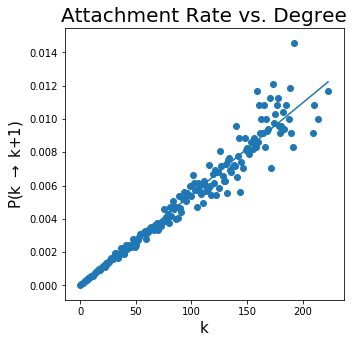

In [19]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 100
start = 500
iterations = 1000

k_incr = test_digraph(price_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

# Barabasi-Albert
 Networkx Built-In

==================================================================================================== Done
Correlation:  0.9357932765539537


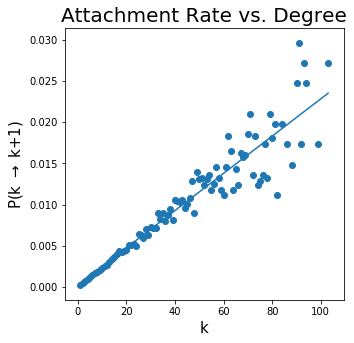

In [52]:
# Graph parameters
size = 1000
m = 1
params = [size, m]

# Test parameters
interval = 100
start = 500
iterations = 1000

k_incr = test_graph(nx.barabasi_albert_graph, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

Personal Implementation

In [8]:
def barabasi_albert_model(size):
    G = nx.Graph()
    G.add_edge(0,1)

    for i in range(len(G),size):
        k_sum = 2*G.number_of_edges()
        
        prob = [ k/k_sum for n,k in G.degree() ]  

        sel_node = np.random.choice(G.nodes(), p=prob)
        G.add_edge(i, sel_node)
        
    return G

==================================================================================================== Done
Correlation:  0.9081470288810733


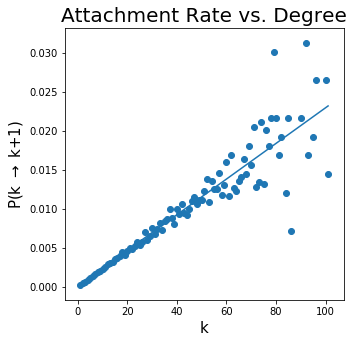

In [9]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 100
start = 500
iterations = 1000

k_incr = test_graph(barabasi_albert_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

# Uniform Random

In [9]:
def uniform_random_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    
    for i in range(len(G),size):
        # len(G) == i
        sel_node = np.random.randint(0,i)
        G.add_edge(i, sel_node)
        
    return G

==================================================================================================== Done
Correlation:  -0.578915016159925


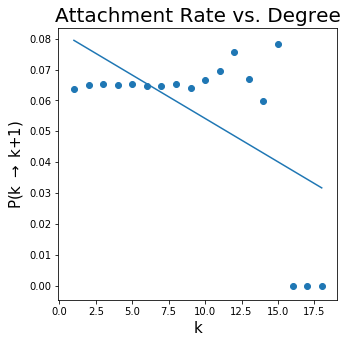

In [26]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 100
start = 500
iterations = 10000

k_incr = test_graph(uniform_random_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

# Time Model

In [15]:
def time_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    
    for i in range(len(G), size):
        nodes = G.nodes()
        nodes_len = len(nodes)
        nodes_sum = sum(nodes)
        
        # randomly select node
        sel_node_prob = np.random.random()
        lower_bound = 0
        sel_node = -1
        
        for x in nodes:
            bucket_size = (nodes_len-x)/(nodes_sum+i)
            upper_bound = lower_bound + bucket_size
            if sel_node_prob < upper_bound and sel_node_prob >= lower_bound:
                sel_node = x
            lower_bound = upper_bound
        
        G.add_edge(i, sel_node)
    
    return G

==================================================================================================== Done
Correlation:  0.23068639883201128


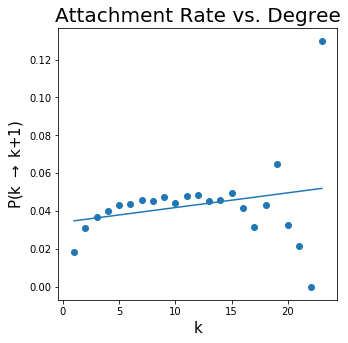

In [16]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 100
start = 500
iterations = 1000

k_incr = test_graph(time_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)

# Geodesic Distance

In [20]:
def mean_geodesic_model(size):
    G = nx.Graph()
    G.add_edge(0,1)
    dist = np.zeros([size, size])
    avg = np.zeros(size)
    
    dist[1][0] = 1
    dist[0][1] = 1
    
    avg[0] = 1
    avg[1] = 1
    
    for i in range(len(G), size):
        mean_geo_dist = [ x/(i-1) for x in avg[:i] ]
        mean_geo_sum = sum(mean_geo_dist)
        
        prob = [ x/mean_geo_sum for x in mean_geo_dist ]
        sel_node = np.random.choice(G.nodes(), p=prob)
        G.add_edge(i, sel_node)
        dist[i,:i] = dist[sel_node,:i]+1
        dist[:i,i] = dist[:i,sel_node]+1
        
        avg[i] = avg[sel_node]+i
        for j in range(i):
            avg[j] = avg[j] + dist[j,sel_node] + 1
    
    #print(avg)
    #print(dist)
    return G

==================================================================================================== Done
Correlation:  -0.577236134578106


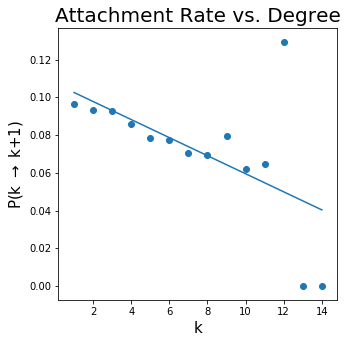

In [22]:
# Graph parameters
size = 1000
params = [size]

# Test parameters
interval = 100
start = 500500
iterations = 1000

k_incr = test_graph(mean_geodesic_model, params, start, interval, iterations)

slope, intercept, r_value, p_value, std_err = model_stats(k_incr);
print("Correlation: ", r_value)